Training data shape: (1700, 11)
Class distribution:
 fetal_health
1.0    1322
2.0     378
Name: count, dtype: int64

Encoded classes: [1. 2.]
Encoded labels: [0 1]
Gradient Boosting fitting time: 0.31 minutes
  gb__learning_rate: 0.1
  gb__max_depth: 3
  gb__n_estimators: 200

Best cross-validation accuracy: 0.9453
Accuracy:  0.9453
Precision: 0.9449
Recall:    0.9453
F1-Score:  0.9444
[[1319    3]
 [  22  356]]
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99      1322
         2.0       0.99      0.94      0.97       378

    accuracy                           0.99      1700
   macro avg       0.99      0.97      0.98      1700
weighted avg       0.99      0.99      0.99      1700


Top 10 Most Important Features:
                                               Feature  Importance
                       abnormal_short_term_variability    0.347211
                              prolongued_decelerations    0.150762
                  mean_

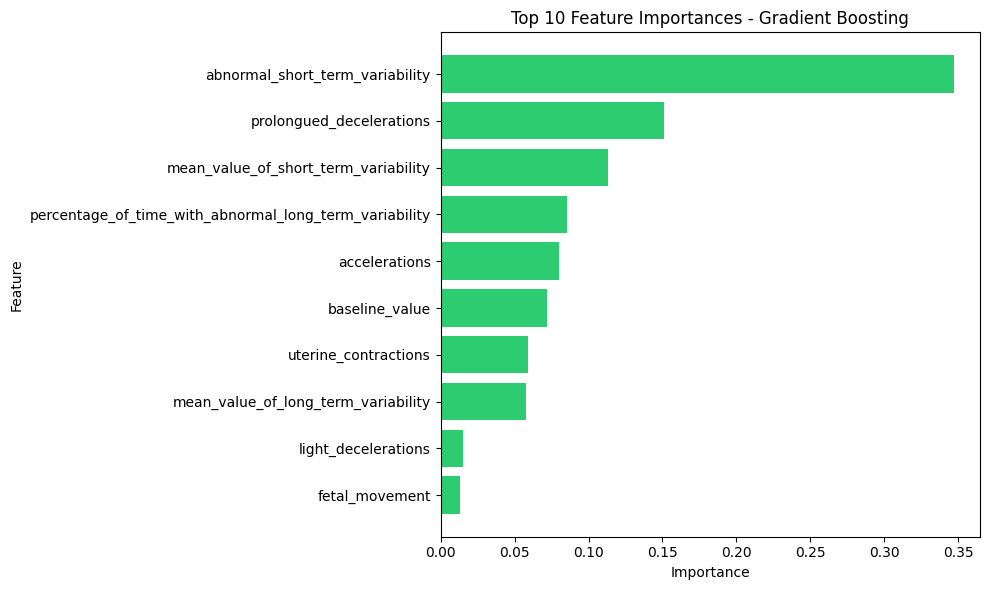

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_score, recall_score, f1_score)
import time

# Setting the random seed for reproducibility
np.random.seed(42)

#Loading the Data
data = '../Data/train_set.csv'
df = pd.read_csv(data)

# Separate features and target
X_train = df.drop(columns=['fetal_health'])
y_train = df['fetal_health']

print("Training data shape:", X_train.shape)
print("Class distribution:\n", y_train.value_counts())

#Encoding the outcome variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
classes = label_encoder.classes_

print(f"\nEncoded classes: {classes}")
print(f"Encoded labels: {np.unique(y_train_encoded)}")

#Cross-Validation
cv_splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Let's Define the different scoring metrics for eval
scoring = {
    'accuracy': 'accuracy',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'f1_weighted': 'f1_weighted'
}

#Gradient Boosting Model
#Creating pipeline with preprocessing
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingClassifier(random_state=42))
])

#Defining hyperparameter grid
param_grid_boost = {
    'gb__learning_rate': [0.01, 0.05, 0.1],
    'gb__max_depth': [3, 5, 7],
    'gb__n_estimators': [100, 200]   # added valid parameter
}

gb_start_time = time.time()

#Initializing GridSearchCV
grid_search_gb = GridSearchCV(
    estimator=gb_pipeline,
    param_grid=param_grid_boost,
    cv=cv_splitter,
    scoring='accuracy',
    n_jobs=-1,
)

grid_search_gb.fit(X_train, y_train_encoded)
gb_end_time = time.time()
print(f"Gradient Boosting fitting time: {(gb_end_time - gb_start_time)/60:.2f} minutes")

#Evaluation
for param, value in grid_search_gb.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation accuracy: {grid_search_gb.best_score_:.4f}")

#Evaluating with Multiple Metrics
best_gb_model = grid_search_gb.best_estimator_

gb_cv_results = cross_validate(best_gb_model, X_train, y_train_encoded,
                                cv=cv_splitter, scoring=scoring)

print(f"Accuracy:  {gb_cv_results['test_accuracy'].mean():.4f}" )
print(f"Precision: {gb_cv_results['test_precision_weighted'].mean():.4f}" )
print(f"Recall:    {gb_cv_results['test_recall_weighted'].mean():.4f}" )
print(f"F1-Score:  {gb_cv_results['test_f1_weighted'].mean():.4f}" )

best_gb_model.fit(X_train, y_train_encoded)
y_pred_gb = best_gb_model.predict(X_train)
gb_cm = confusion_matrix(y_train_encoded, y_pred_gb)
print(gb_cm)

print(classification_report(y_train_encoded, y_pred_gb, target_names=[str(c) for c in classes]))

#Feature IMPORTANCE
features = X_train.columns
feature_importance_gb = best_gb_model.named_steps['gb'].feature_importances_   # FIXED

# Create dataframe
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance_gb
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10],
         feature_importance_df['Importance'][:10],
         color='#2ecc71')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances - Gradient Boosting')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()